In [17]:
from minigraphs.data import load_graph
import networkx as nx 
import matplotlib.pyplot as plt

params = {
    "figure.dpi" : 300
}

plt.rcParams.update(params)
spartan_green = '#18453B'

# Large Networks Slide

**Simulation on large networks is expensive:** Let's highlight how simulation on large networks presents scalability problems

In [19]:
hamsterster = load_graph('hamsterster')

#pos_hamsterster = nx.forceatlas2_layout(hamsterster, max_iter=300)
pos_hamsterster = nx.circular_layout(hamsterster)

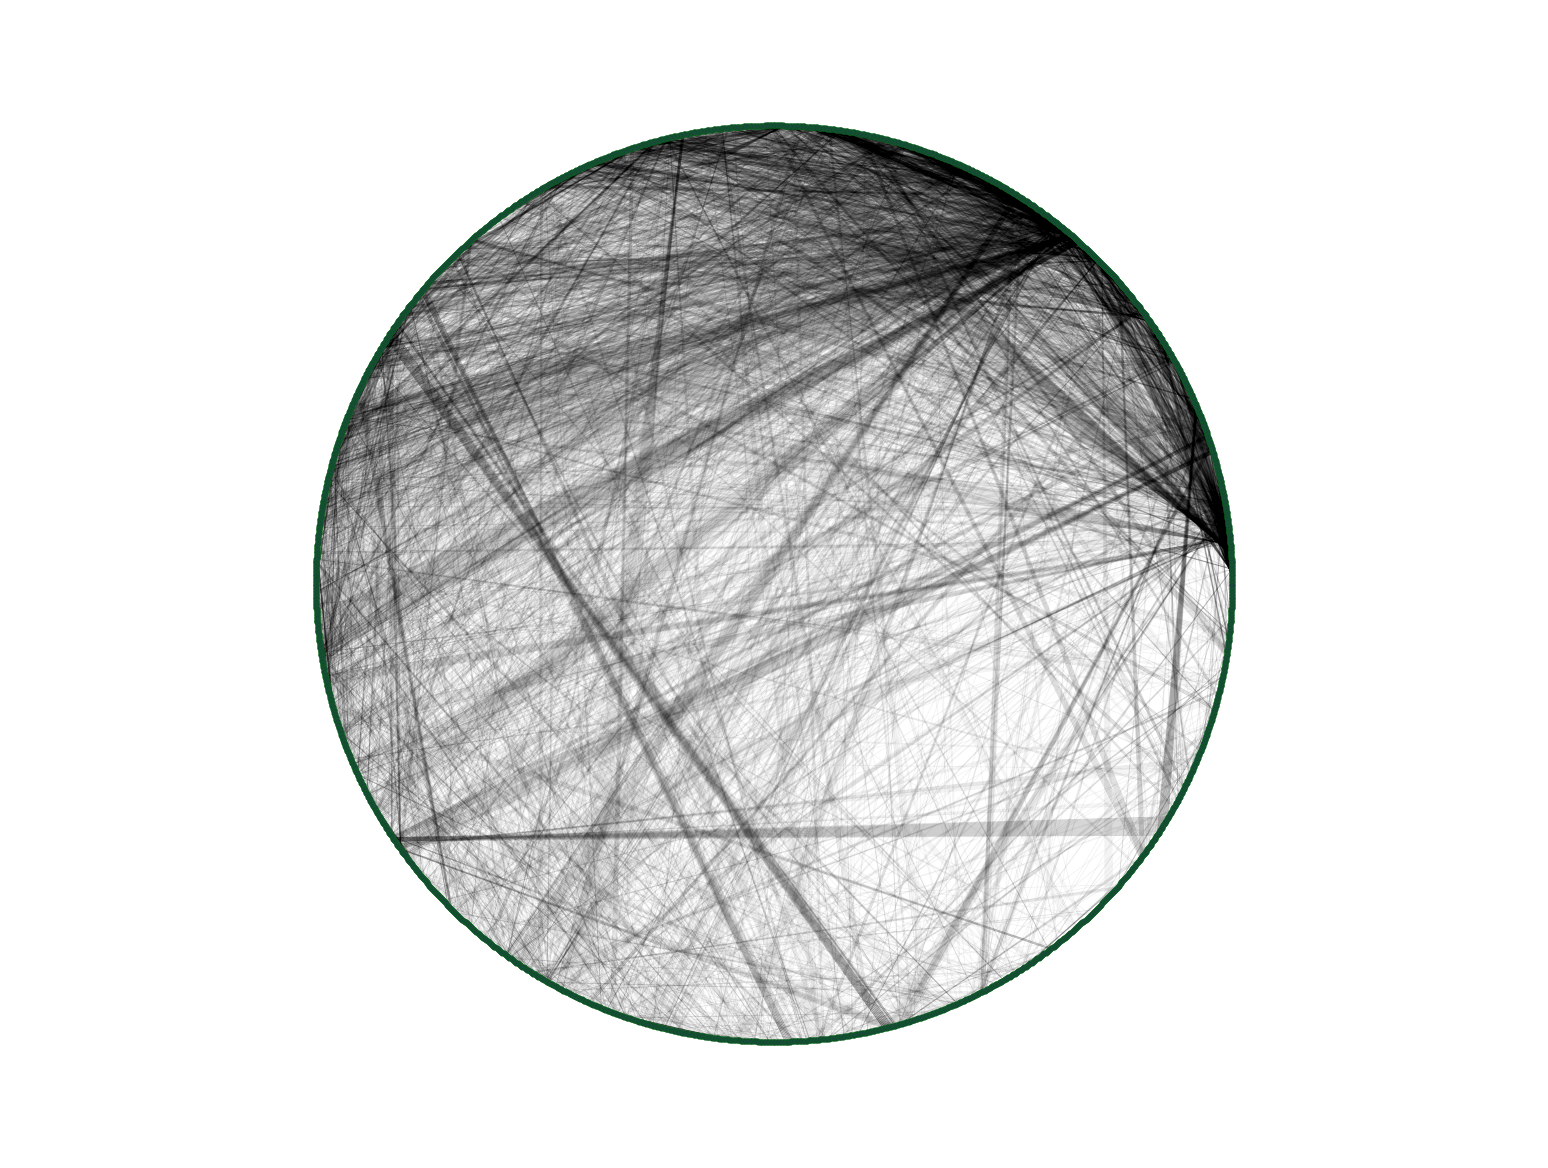

In [20]:
node_attributes={
    'node_size': 2,
    'node_color': spartan_green,
    'edgecolors': 'g',
    'linewidths': 0.05,
}

edge_attributes={
    'alpha': 0.05,
    'width':0.2
}
nx.draw_networkx_nodes(
    hamsterster,
    pos_hamsterster,
    **node_attributes,
)

nx.draw_networkx_edges(
    hamsterster,
    pos_hamsterster,
    **edge_attributes,
)

ax = plt.gca()
ax.axis('equal')
ax.set_frame_on(False)

plt.savefig("hamsterster.png", transparent=True, bbox_inches='tight')

In [21]:
from mesa.batchrunner import batch_run
from minigraphs.simulation import SIRModel
from functools import partial 
import pandas as pd

params_simulation = {
    'gamma': 0.1,
    'beta': 0.1, 
    'n_infected': 1
}

dfs = []
iterations = [10, 30, 100]

for n_iterations in iterations:
    # Simulate SIR
    results = batch_run(
        partial(SIRModel, network=hamsterster),
        params_simulation,
        number_processes=None,
        iterations=n_iterations,
        data_collection_period=1,
        max_steps=150
    )

    dfs.append(results)

df_results = pd.concat((pd.DataFrame(table) for table in dfs), keys=iterations).drop(params_simulation.keys(), axis=1)
df_results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

RunId  iteration  Step     S    I   R
10  0          6          6     0  1999    1   0
    1          6          6     1  1997    3   0
    2          6          6     2  1981   19   0
    3          6          6     3  1899  100   1
    4          6          6     4  1645  342  13
...          ...        ...   ...   ...  ...  ..
100 15095     98         98   146  1999    1   0
    15096     98         98   147  1999    1   0
    15097     98         98   148  1999    1   0
    15098     98         98   149  1999    1   0
    15099     98         98   150  1999    1   0

[21140 rows x 6 columns]

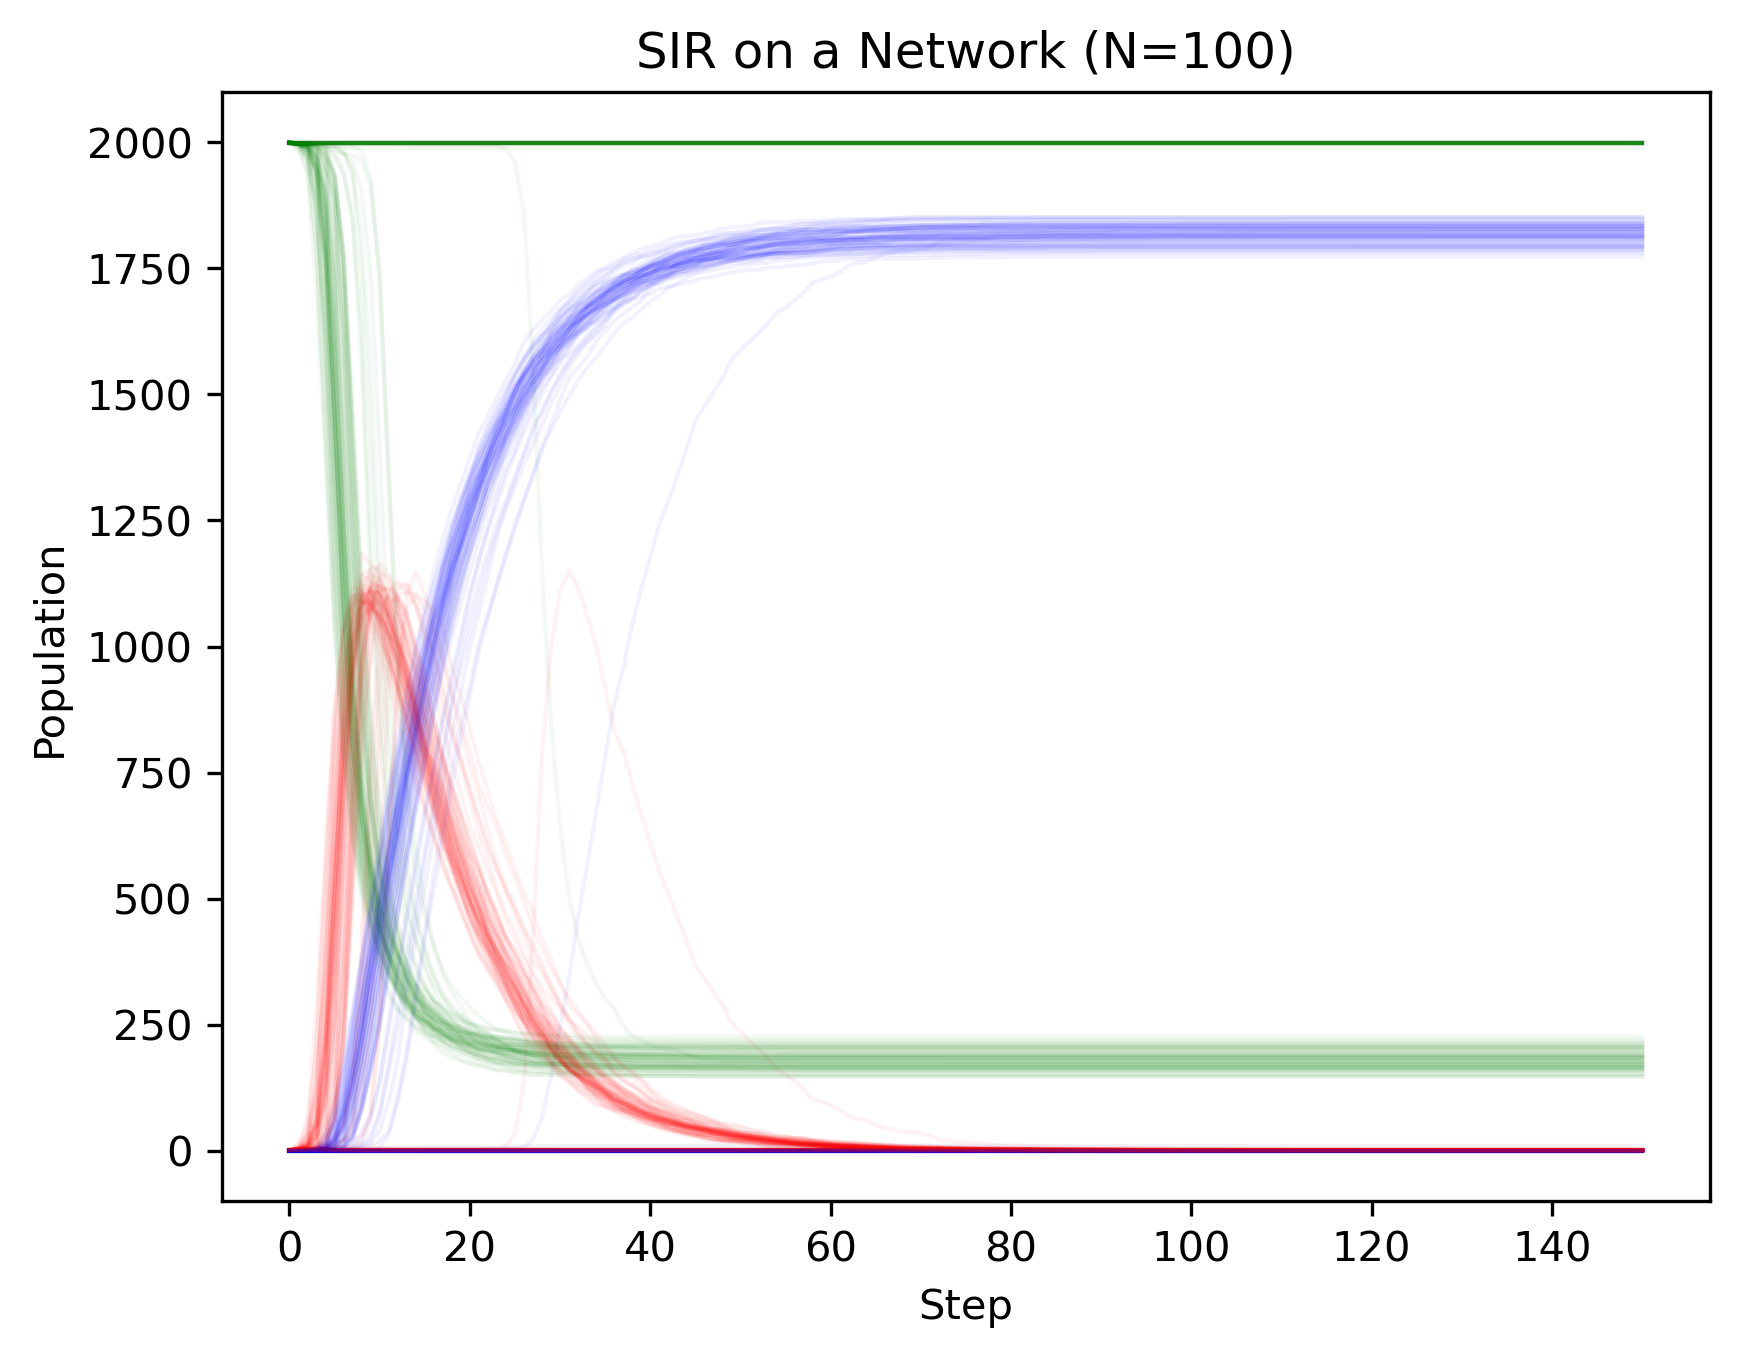

In [32]:
import seaborn as sns 

iterations = df_results.loc[100]['iteration'].unique()
df_plot = df_results.loc[100]

for iteration in iterations:
    sns.lineplot(
        df_plot.loc[df_plot['iteration'] == iteration],
        x = 'Step',
        y = 'S',
        color='g',
        linewidth=1.0,
        alpha=0.05
    )

    sns.lineplot(
        df_plot.loc[df_plot['iteration'] == iteration],
        x = 'Step',
        y = 'I',
        color='r',
        linewidth=1.0,
        alpha=0.05
    )

    sns.lineplot(
        df_plot.loc[df_plot['iteration'] == iteration],
        x = 'Step',
        y = 'R',
        color='b',
        linewidth=1.0,
        alpha=0.05
    )

plt.ylabel("Population")
plt.xlabel("Step")
plt.title("SIR on a Network (N=100)")
plt.savefig("sir_network.png", transparent=True, bbox_inches='tight')

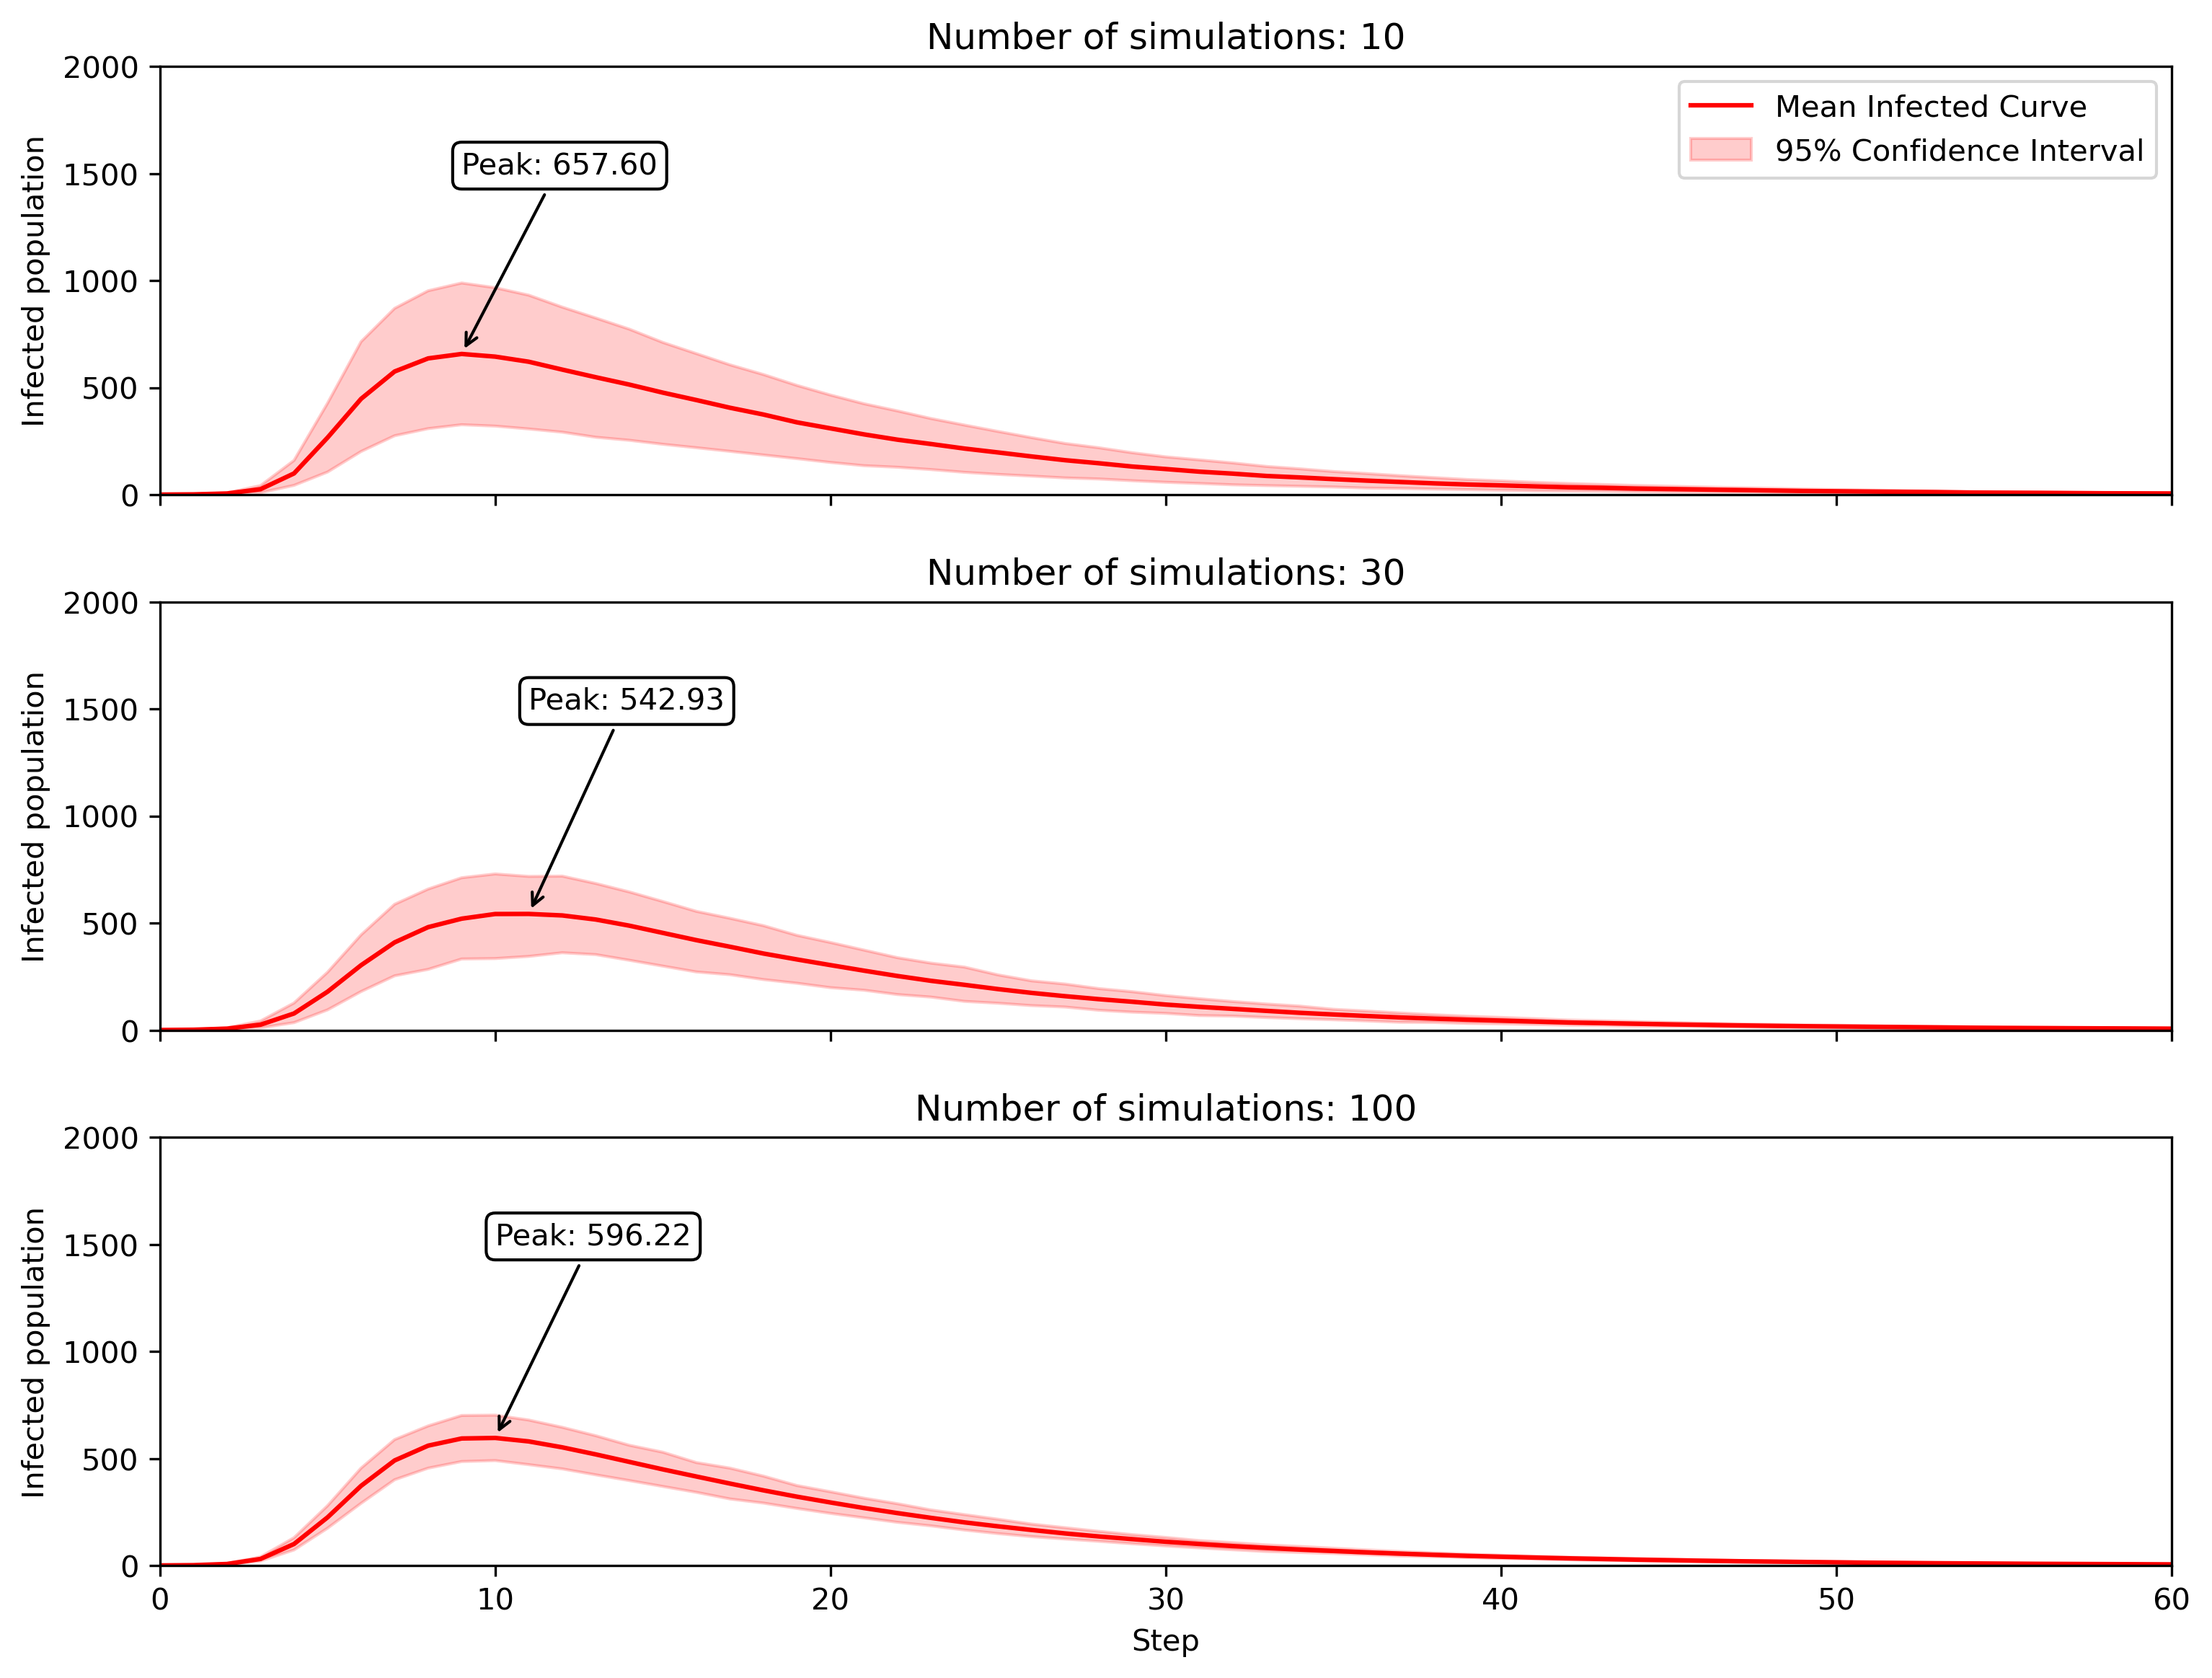

In [ ]:


fig, ax = plt.subplots(3,1,figsize=(12,9), sharex=True)

for i, n_iterations in enumerate(iterations):
    df = df_results.loc[n_iterations]

    # Mean simulation
    df_mean = df.groupby('Step').mean()

    # Mean peak
    peak = df_mean['I'].max()
    peak_loc = df_mean['I'].argmax()
    
    g = sns.lineplot(
        df,
        x='Step',
        y='I',
        color='red',
        ax=ax[i]
    )

    g.set(
        ylim=[0, 2000],
        xlim=[0, 60],
        title=f"Number of simulations: {n_iterations}",
        ylabel="Infected population",
    )
    
    g.annotate(xy=(peak_loc, peak), xytext=(peak_loc, 1500),text=f"Peak: {peak:.2f}", bbox={'boxstyle':'round', 'fc':'w'}, arrowprops={'arrowstyle':'->'})

    if i == 0:
        g.legend(["Mean Infected Curve", "95% Confidence Interval"])

    g.figure.subplots_adjust(hspace=0.25)

plt.savefig('sir_uncertainty.png', transparent=True, bbox_inches='tight')

# Surrogate alternatives
**We'd like to generate small network surrogates.** We can create networks from the bottom up or try to replicate existing structures

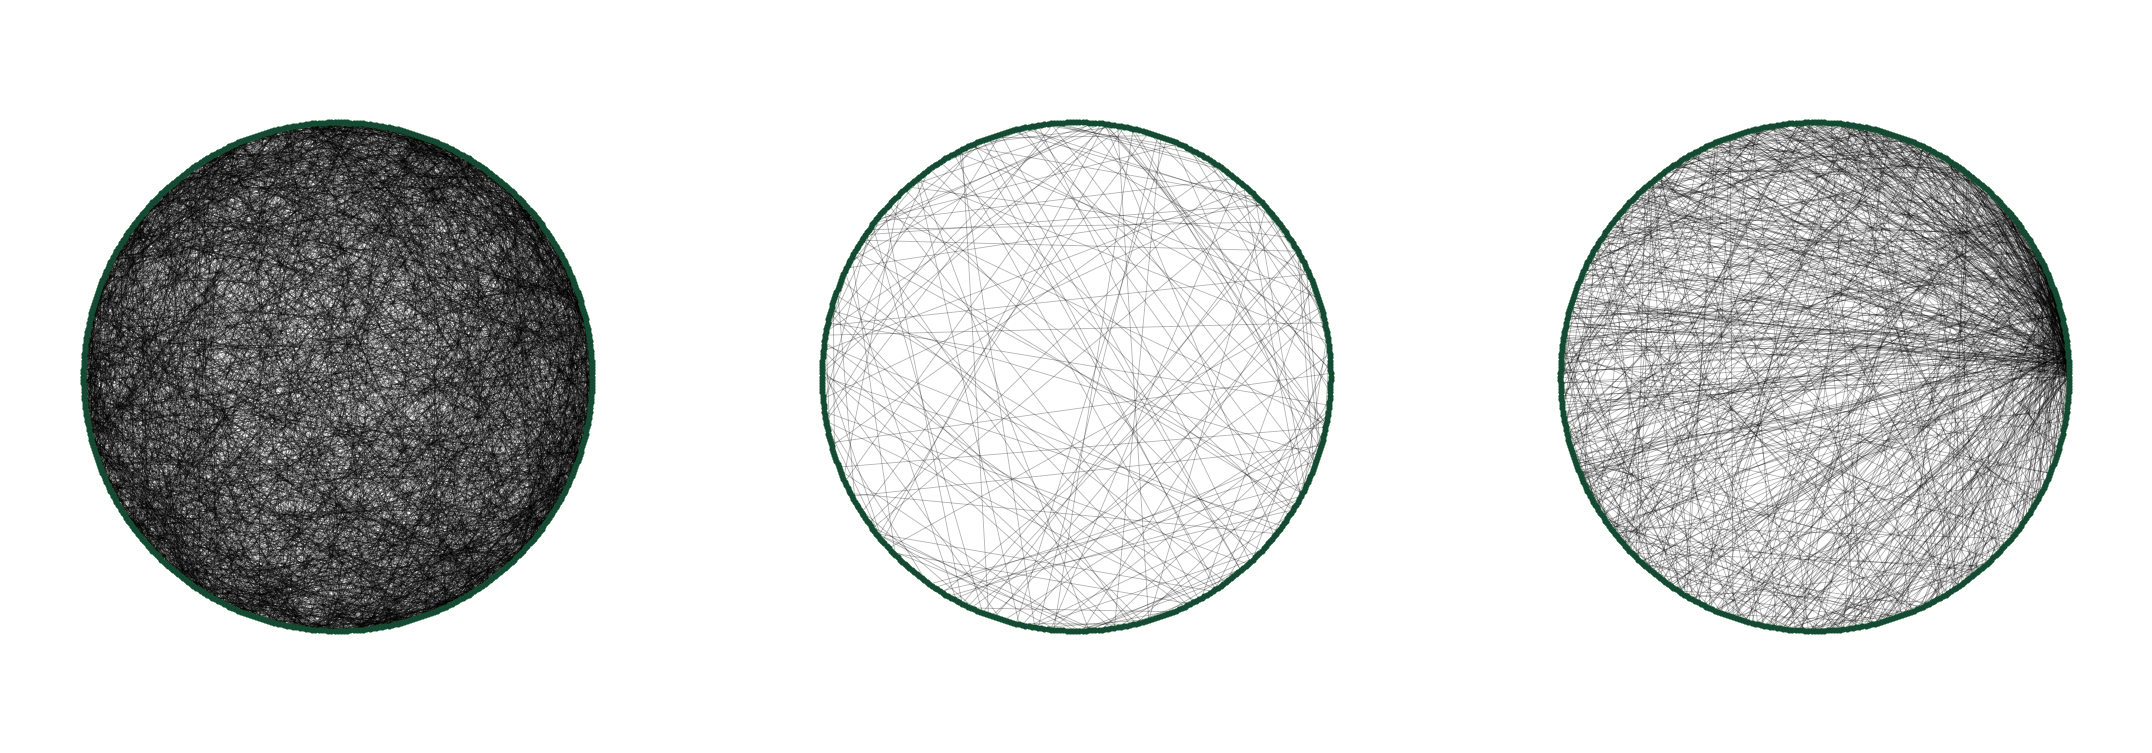

In [237]:
n_nodes = 500

graphs = {
   "er_graph" : nx.erdos_renyi_graph(n_nodes, 0.025),
   "ws_graph" : nx.watts_strogatz_graph(n_nodes, 5, 0.2),
   "bs_graph" : nx.barabasi_albert_graph(n_nodes, 2)
}




fig, ax = plt.subplots(1,3, figsize=(9,3))
for i, graph in enumerate(graphs.values()):
   pos = nx.circular_layout(graph)

   nx.draw_networkx_nodes(graph, pos, **node_attributes, ax=ax[i])
   nx.draw_networkx_edges(graph, pos, alpha=0.3, width=0.2, ax=ax[i])
   ax[i].axis('equal')
   ax[i].set_frame_on(False)

plt.savefig("graphs.png", transparent=True, bbox_inches='tight')

In [212]:
results_graphs = []
n_iterations = 50

for name, graph in graphs.items():
    # Simulate
    results = batch_run(
        partial(SIRModel, network=graph),
        parameters=params_simulation,
        number_processes=1,
        iterations=n_iterations,
        max_steps=80,
        data_collection_period=1
    )

    results_graphs.append(results)

df_graphs = pd.concat((pd.DataFrame(result) for result in results_graphs), keys=graphs.keys(), names=['graph', 'id'])
df_graphs

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

RunId  iteration  Step  gamma  beta  n_infected    S   I  R
graph    id                                                               
er_graph 0         0          0     0    0.1   0.1           1  499   1  0
         1         0          0     1    0.1   0.1           1  497   3  0
         2         0          0     2    0.1   0.1           1  492   8  0
         3         0          0     3    0.1   0.1           1  481  19  0
         4         0          0     4    0.1   0.1           1  461  37  2
...              ...        ...   ...    ...   ...         ...  ...  .. ..
bs_graph 4045     49         49    76    0.1   0.1           1  499   1  0
         4046     49         49    77    0.1   0.1           1  499   1  0
         4047     49         49    78    0.1   0.1           1  499   1  0
         4048     49         49    79    0.1   0.1           1  499   1  0
         4049     49         49    80    0.1   0.1           1  499   1  0

[12150 rows x 9 columns]

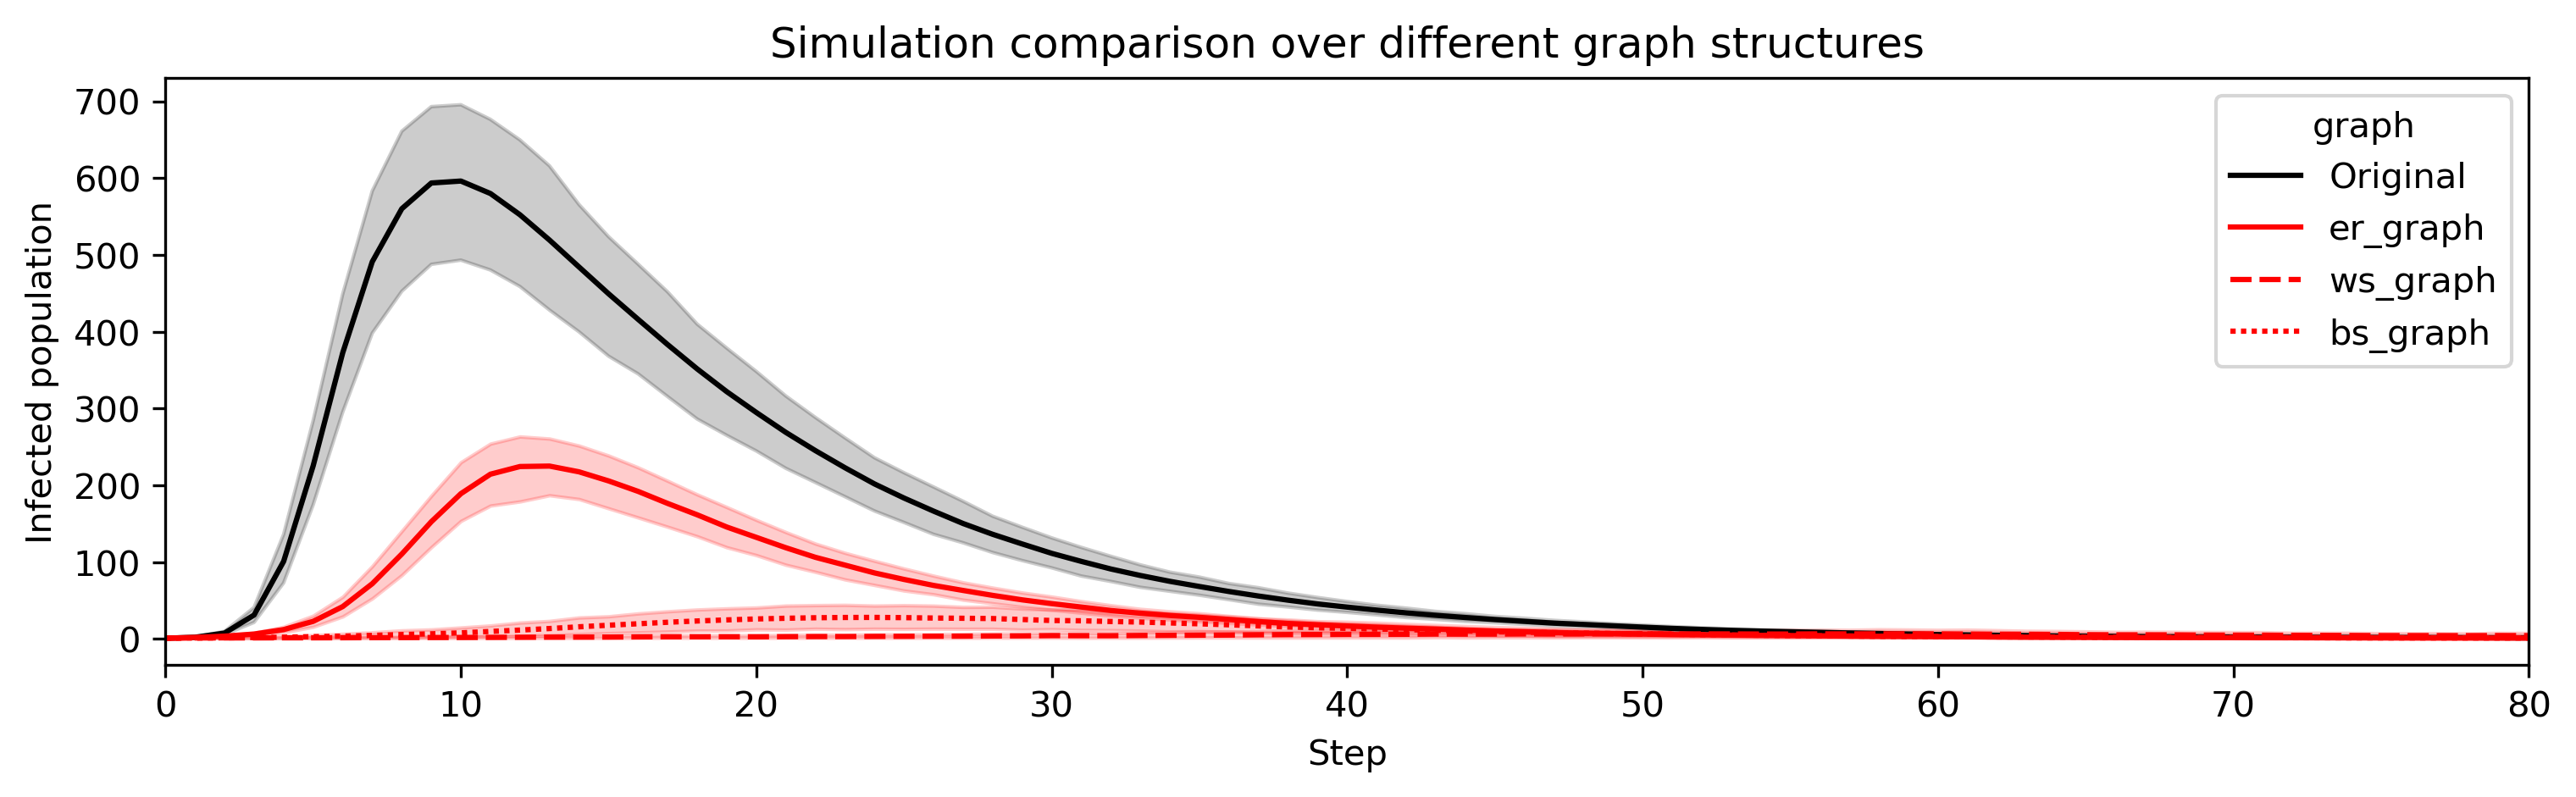

In [254]:
fig, ax = plt.subplots(figsize=(12,3))

sns.lineplot(
    df_results.loc[100],
    color='k',
    x='Step',
    y='I',
    label='Original'
)

sns.lineplot(
    df_graphs,
    x='Step',
    y='I',
    color='r',
    style='graph'
)



ax.set(
    title="Simulation comparison over different graph structures",
    ylabel="Infected population",
    xlim=[0,80]
)

plt.savefig('sir_graphs.png', transparent=True, bbox_inches='tight')

In [227]:
from minigraphs.reduction import CoarseNET

coarsener = CoarseNET(0.75, hamsterster)
coarsener.coarsen()

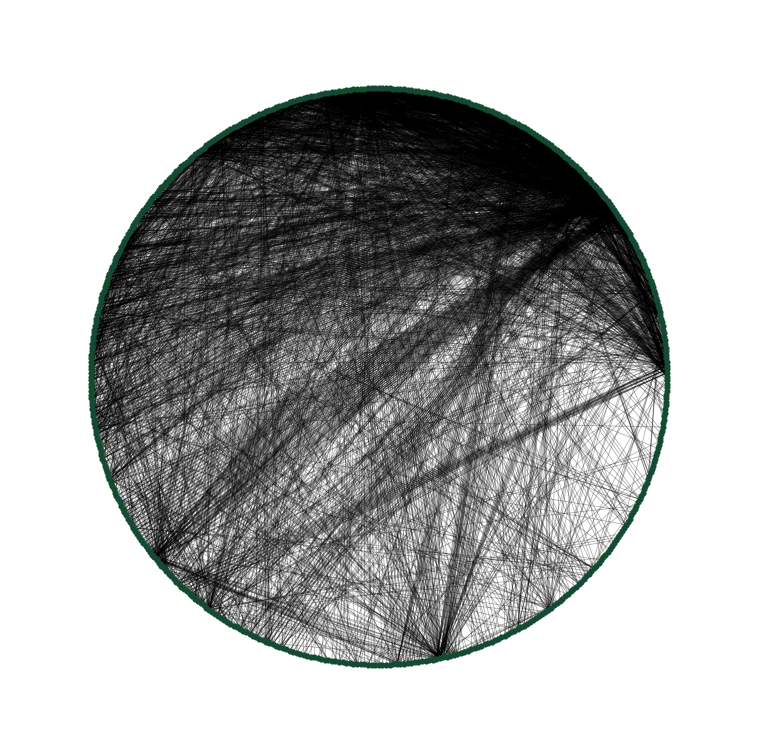

In [234]:
fig, ax = plt.subplots(figsize=(3,3))

graph = nx.Graph(coarsener.G_coarse_)
pos = nx.circular_layout(graph)

nx.draw_networkx_nodes(graph, pos, **node_attributes)
nx.draw_networkx_edges(graph, pos, alpha=0.3, width=0.2)
ax.axis('equal')
ax.set_frame_on(False)

plt.savefig("graph_coarse.png", transparent=True, bbox_inches='tight')

In [241]:
df_coarsen = pd.DataFrame(
    batch_run(
        partial(SIRModel, network=nx.Graph(nx.convert_node_labels_to_integers(coarsener.G_coarse_))),
        params_simulation,
        number_processes=1,
        data_collection_period=1,
        max_steps=80,
        iterations=50,
    )
)

  0%|          | 0/50 [00:00<?, ?it/s]

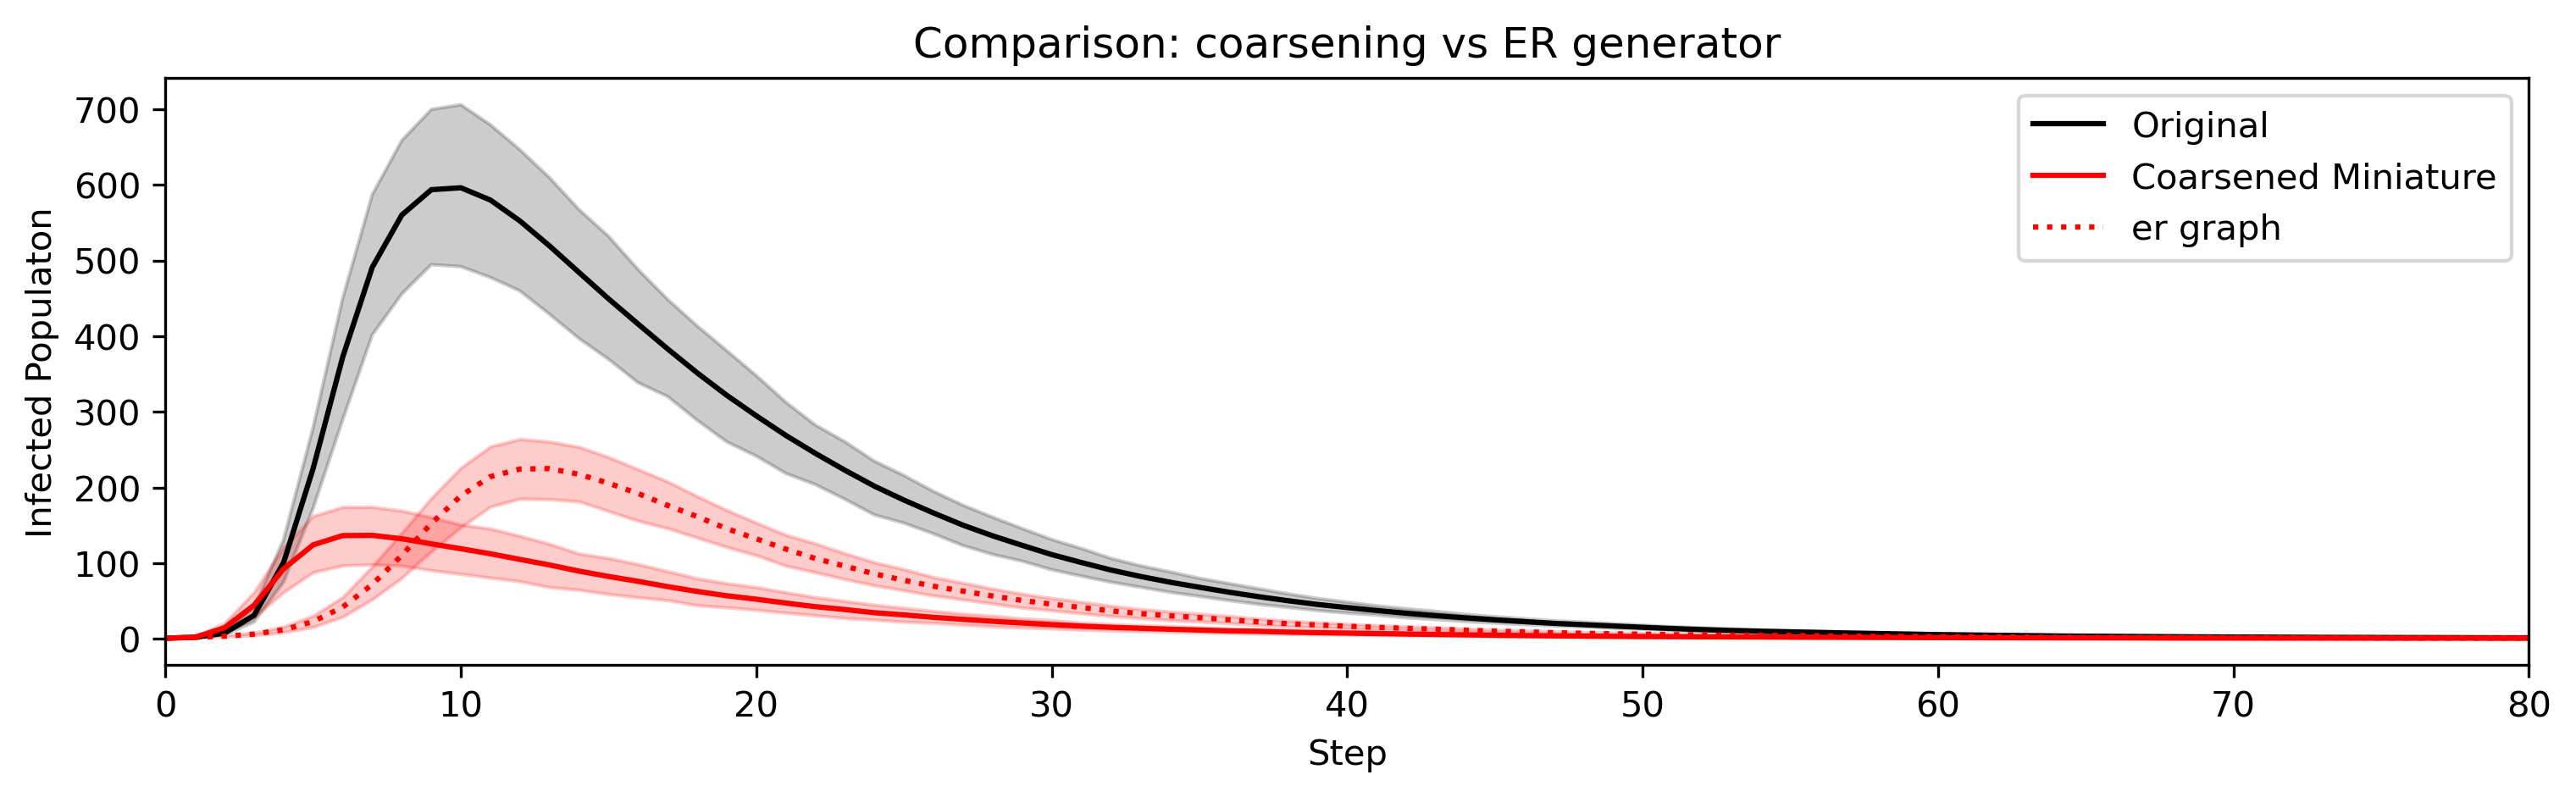

In [297]:
plt.figure(figsize=(12, 3))
sns.lineplot(df_results.loc[100], x='Step', y='I', label='Original', color='k')
sns.lineplot(df_coarsen.reset_index(), x='Step', y='I', label='Coarsened Miniature', color='r')
sns.lineplot(df_graphs.loc['er_graph'], x='Step', y='I', label='er graph', color='r', linestyle=':')

plt.xlim([0,80 ])
plt.ylabel("Infected Populaton")
plt.title("Comparison: coarsening vs ER generator")

plt.savefig("sir_coarsen.png", transparent=True, bbox_inches='tight')

In [281]:
from minigraphs.metrics import graph_spectrum
import numpy as np 

reduction = np.linspace(0.5, 0.95, 20)

results_sir_coarsening = []

miniatures = []
for fraction in reduction:
    coarsener = CoarseNET(fraction, hamsterster)
    coarsener.coarsen()

    miniatures.append(coarsener.G_coarse_)

    results_sir_coarsening.append(
        batch_run(
            partial(SIRModel, network=nx.convert_node_labels_to_integers(nx.Graph(coarsener.G_coarse_))),
            parameters=params_simulation,
            iterations=20,
            max_steps=80,
            data_collection_period=1,
        )
    )


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

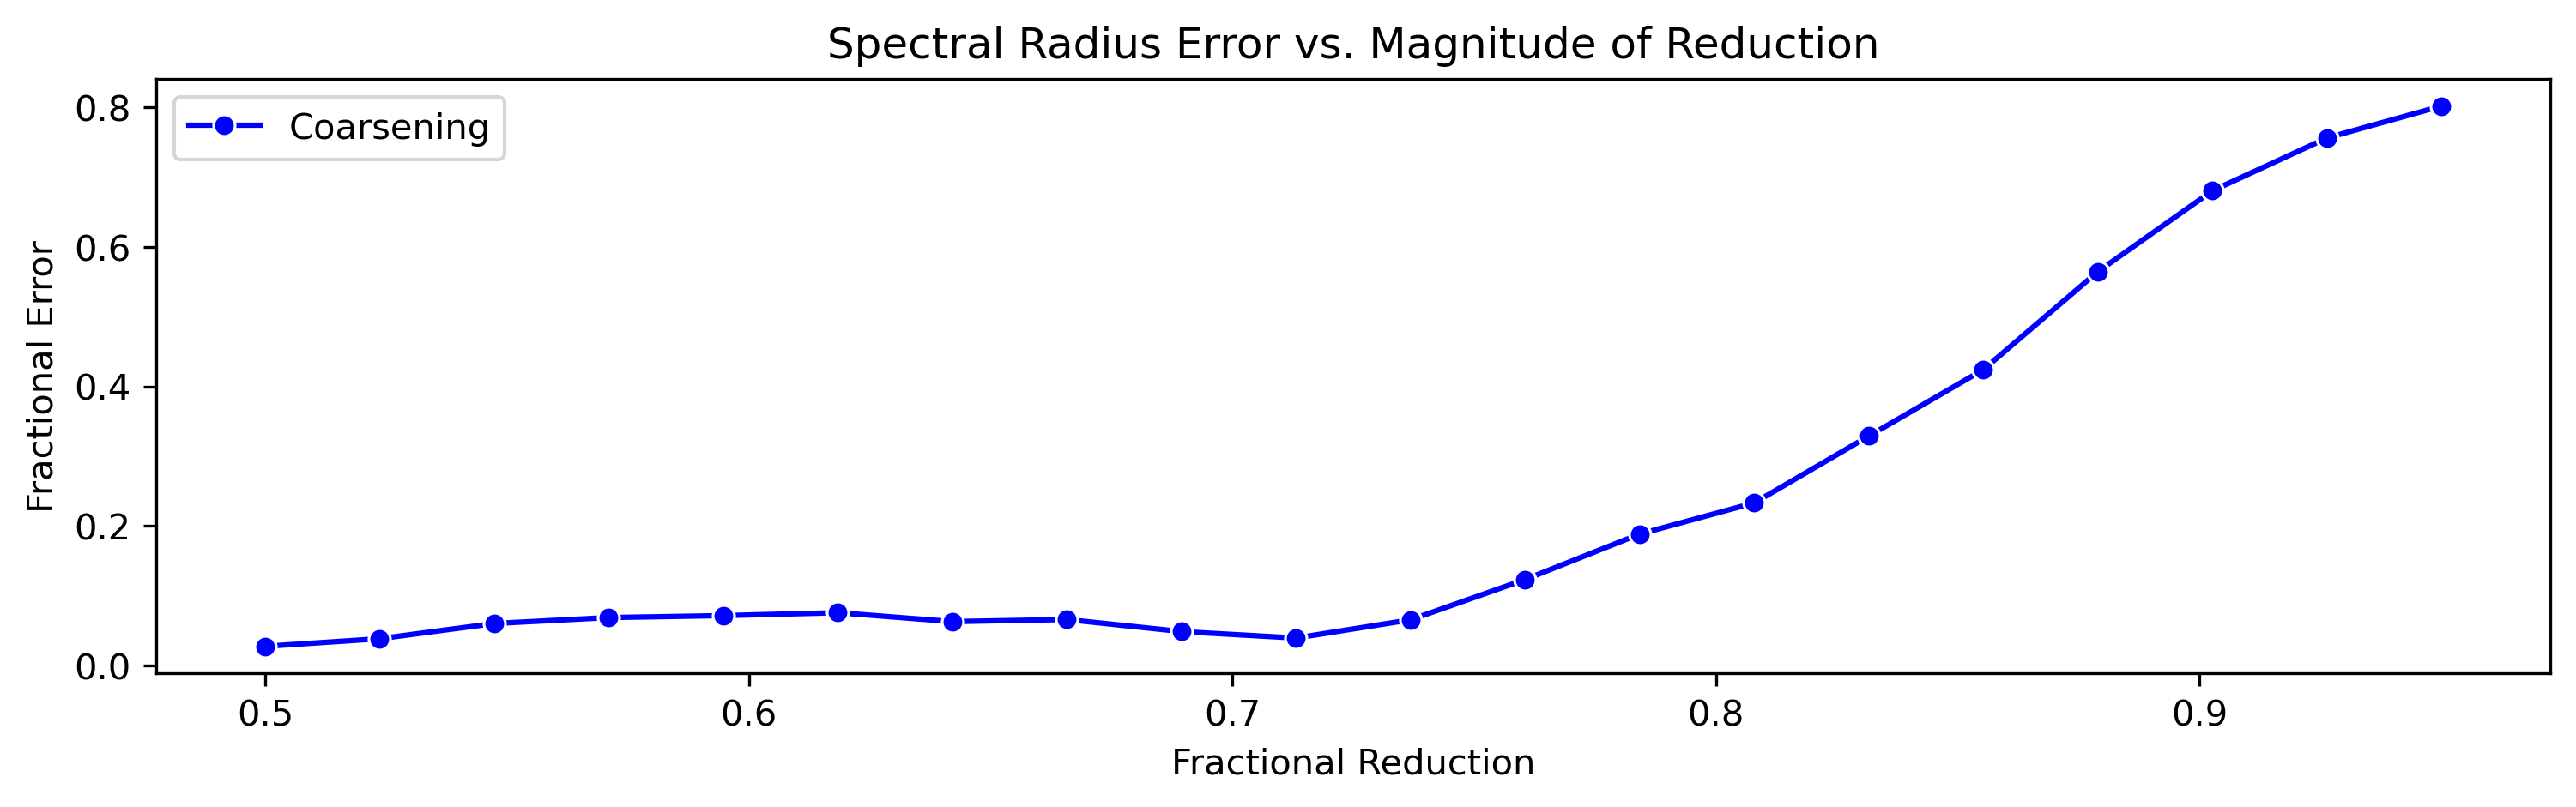

In [371]:
fig = plt.figure(figsize=(12, 3))

def spectral_radius(graph):
    return graph_spectrum(graph)[0]

rad_hamsterster = spectral_radius(hamsterster)

sns.lineplot(x=reduction, y=(np.abs(spectral_radius(g) - rad_hamsterster)/rad_hamsterster for g in miniatures), marker='o', color='blue', label='Coarsening')

plt.xlabel("Fractional Reduction")
plt.ylabel("Fractional Error")
plt.title("Spectral Radius Error vs. Magnitude of Reduction")
plt.savefig("coarsening_error.png", transparent=True, bbox_inches='tight')

/var/folders/qy/xm3nvh3j23z3_29nd070fgdm0000gn/T/ipykernel_67616/3352837323.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/qy/xm3nvh3j23z3_29nd070fgdm0000gn/T/ipykernel_67616/3352837323.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


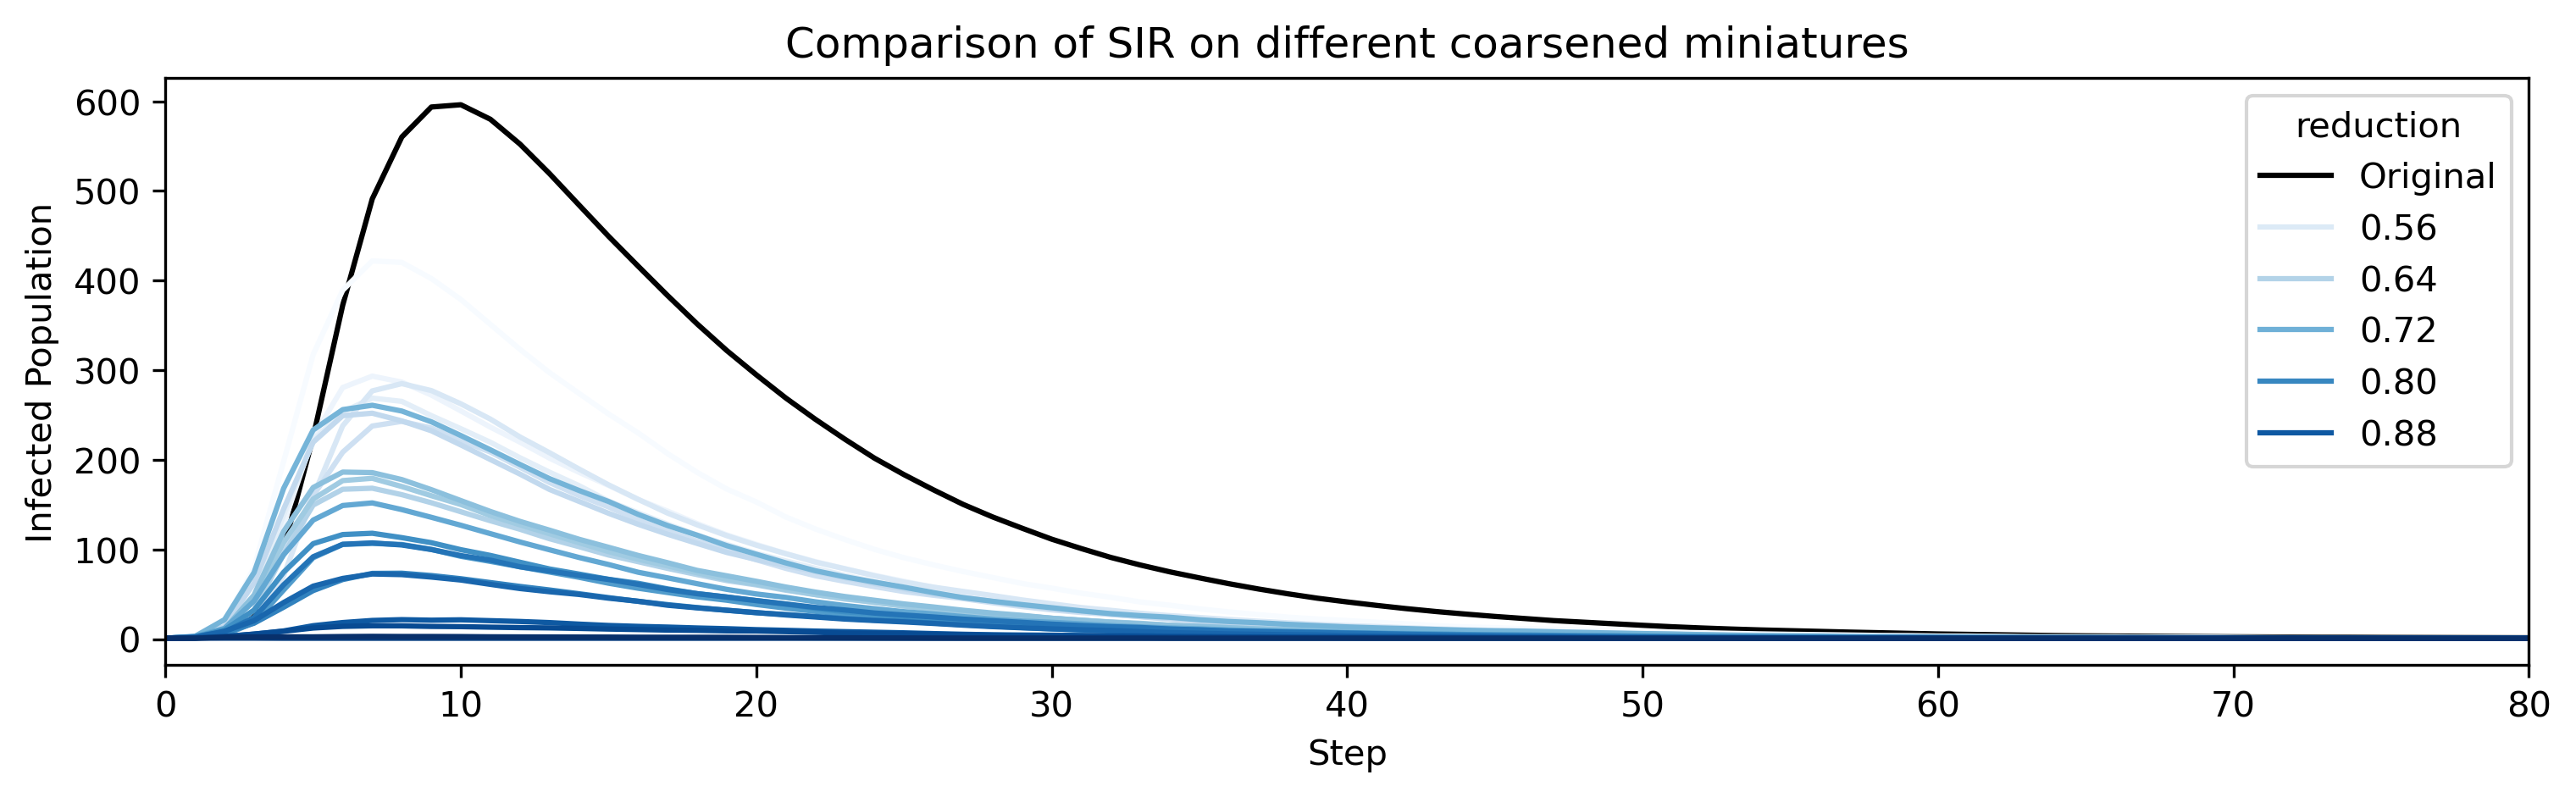

In [372]:
df_sir_coarsening = pd.concat((pd.DataFrame(res) for res in results_sir_coarsening), keys=reduction, names=['reduction', 'id'])

plt.figure(figsize=(12, 3))
sns.lineplot(
    df_results.loc[100],
    x='Step',
    y='I',
    ci=None,
    label='Original',
    color='k'
)

sns.lineplot(
    df_sir_coarsening.reset_index(),
    x='Step',
    y='I',
    hue='reduction',
    ci=None,
    palette=plt.get_cmap('Blues'),
)

plt.xlim([0,80])
plt.ylabel("Infected Population")
plt.title("Comparison of SIR on different coarsened miniatures")
plt.savefig("sir_coarsen_all.png", transparent=True, bbox_inches='tight')


In [316]:
from minigraphs.mcmc import SimulatedAnnealing
from minigraphs.mcmc.chains import SubgraphBoundary

n_steps = 5000
rate = n_steps / 10 
beta = lambda step: np.exp(step/rate)

fractions = np.arange(0.75, 1.0, 0.05)
samples = []
results_mh = []

for fraction in reduction[-10:]:
    size = int(2000 * (1 - fraction))

    annealer = SimulatedAnnealing(
        chain = SubgraphBoundary(hamsterster, size, 10), 
        energy = lambda graph: - spectral_radius(graph),
        schedule = beta,
        max_steps=n_steps
    )

    annealer.run()

    results_mh.append(
        pd.DataFrame(
            batch_run(
                partial(SIRModel, network=nx.convert_node_labels_to_integers(nx.Graph(annealer.best_graph_[0]))),
                parameters=params_simulation,
                number_processes=None,
                iterations=30,
                data_collection_period=1,
                max_steps=80
            )
        )
    )

    samples.append(annealer.best_graph_[0])



100%|██████████| 5000/5000 [00:31<00:00, 156.59it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:27<00:00, 179.00it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:26<00:00, 186.83it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:23<00:00, 214.59it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:20<00:00, 247.05it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:17<00:00, 283.52it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:14<00:00, 338.33it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:12<00:00, 409.66it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:09<00:00, 543.89it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:06<00:00, 784.36it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

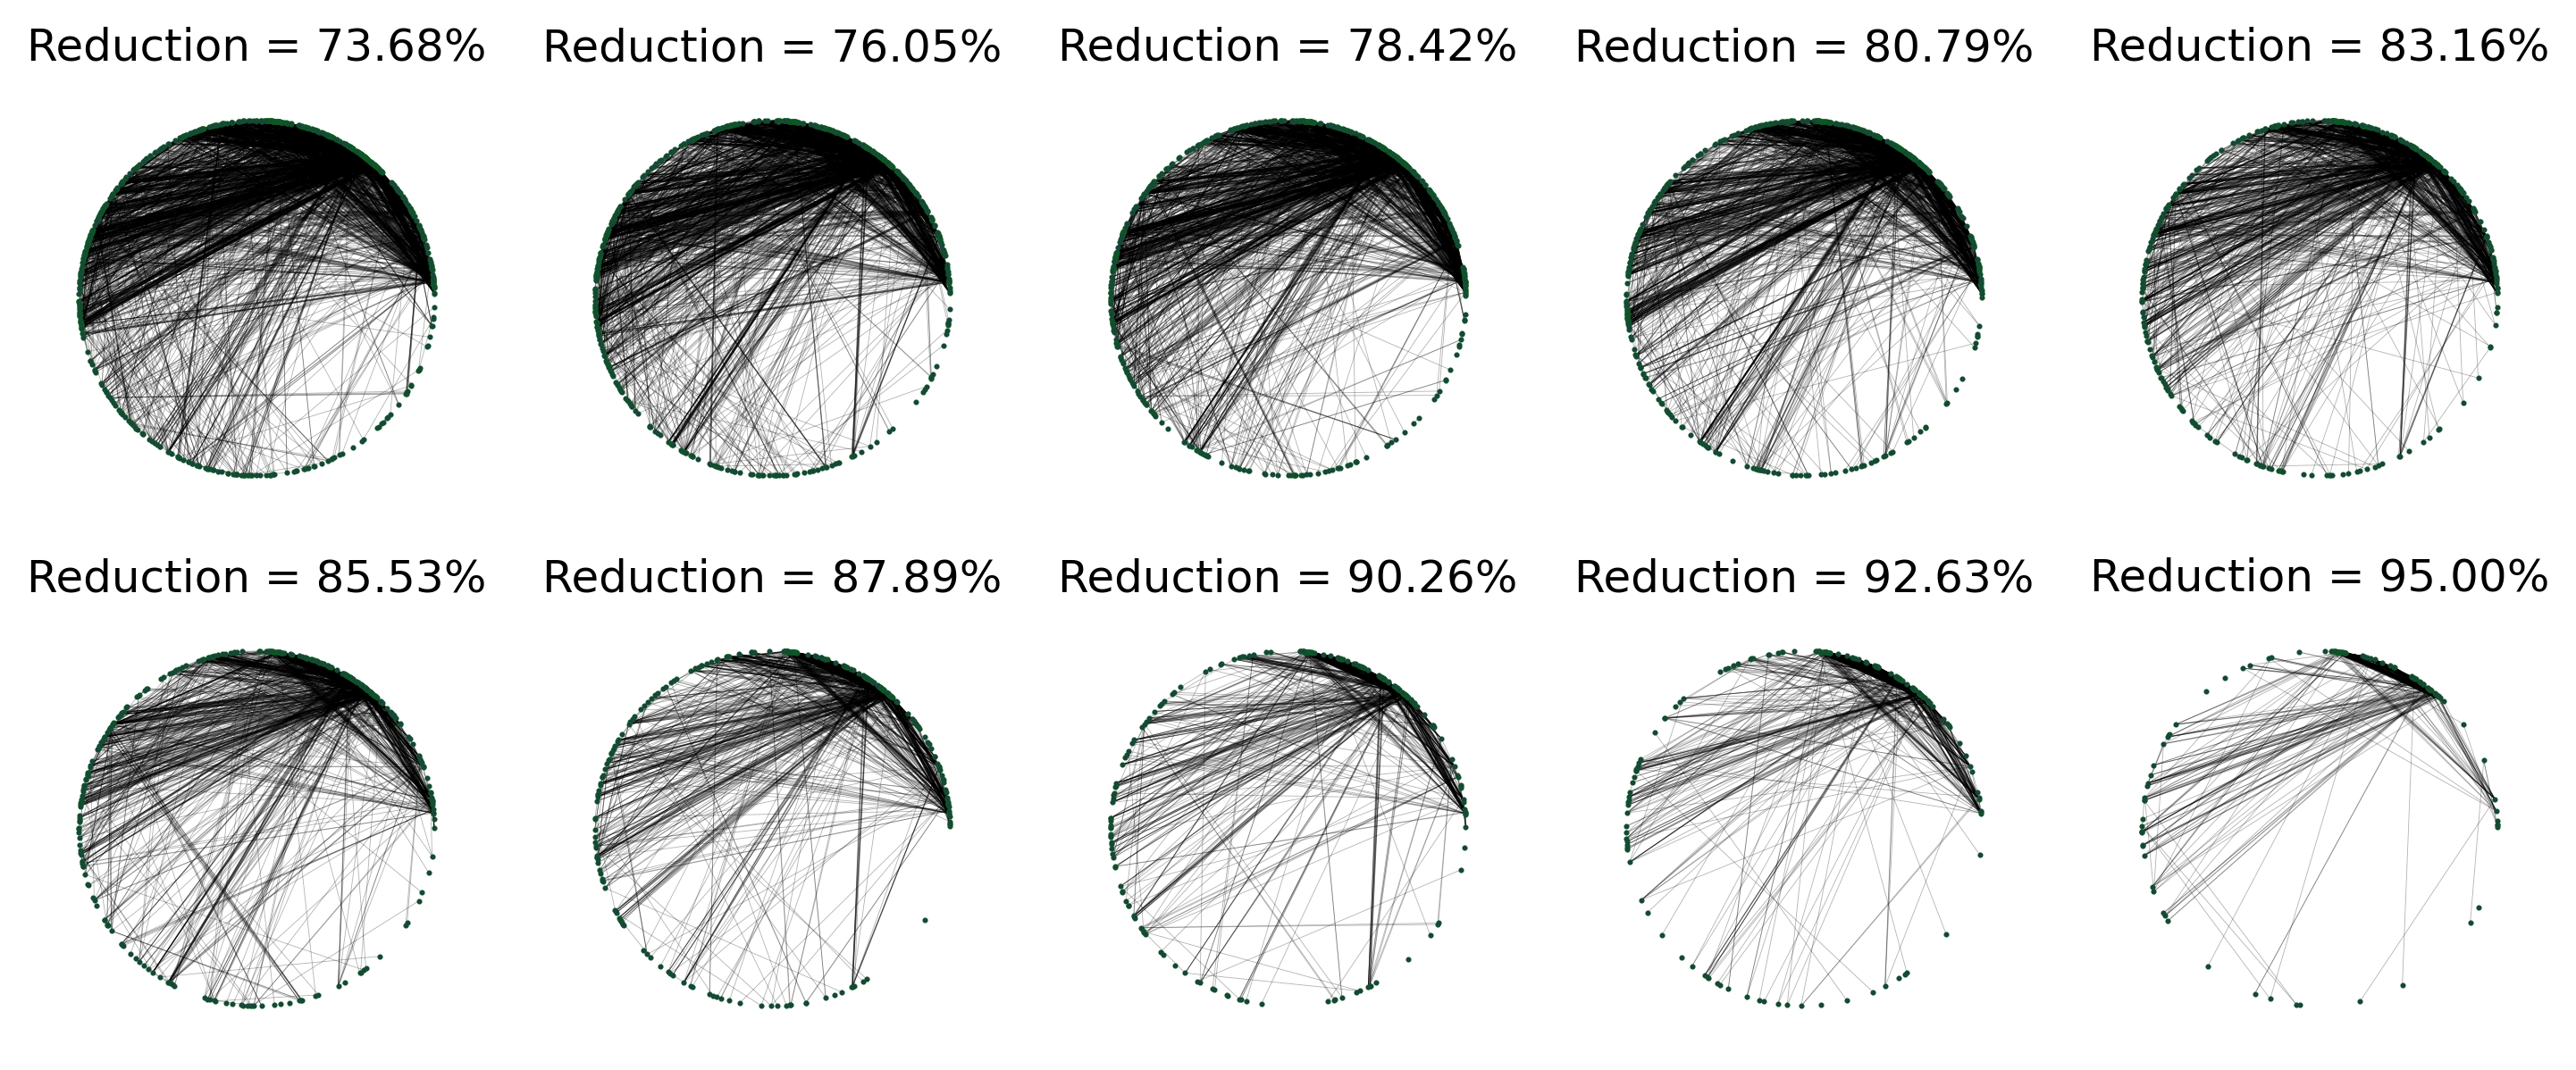

In [332]:
fig, ax = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey=True)

for i, fraction in enumerate(reduction[-10:]):
    ax_current = np.ravel(ax)[i]
    nx.draw_networkx_nodes(
        hamsterster,
        pos_hamsterster,
        nodelist=samples[i],
        **node_attributes,
        ax = ax_current
    )

    nx.draw_networkx_edges(
        samples[i],
        pos_hamsterster,
        alpha=0.3,
        width=0.2,
        ax=ax_current
    )

    ax_current.set_title(f"Reduction = {fraction * 100:.2f}%")
    ax_current.set_box_aspect(True)
    ax_current.set_frame_on(False)

fig.subplots_adjust(hspace=-0.25)

plt.savefig('graphs_mh.png', transparent=True, bbox_inches='tight')
    

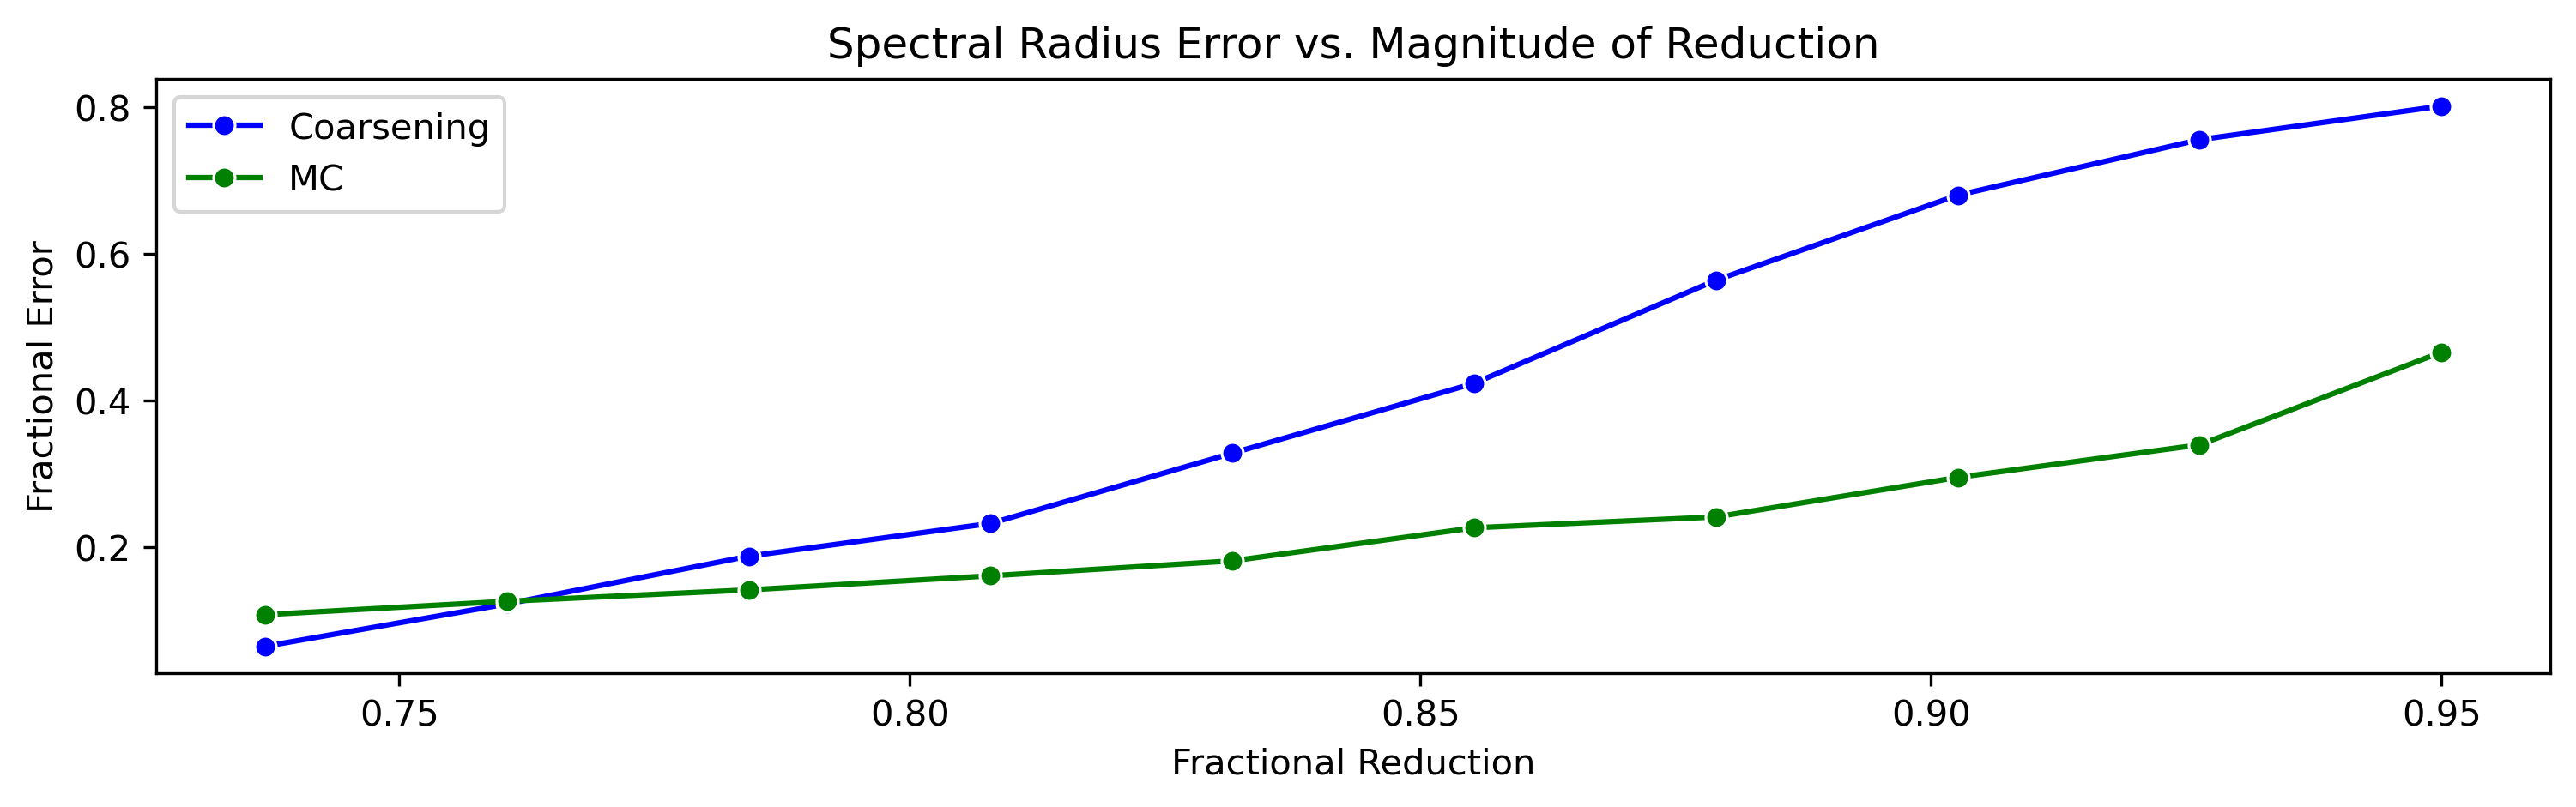

In [373]:
fig = plt.figure(figsize=(12, 3))

def spectral_radius(graph):
    return graph_spectrum(graph)[0]

rad_hamsterster = spectral_radius(hamsterster)

sns.lineplot(x=reduction[-10:], y=(np.abs(spectral_radius(g) - rad_hamsterster)/rad_hamsterster for g in miniatures[-10:]), marker='o', color='blue', label='Coarsening')
sns.lineplot(x=reduction[-10:], y=(np.abs(spectral_radius(g) - rad_hamsterster)/rad_hamsterster for g in samples), marker='o', color='green', label='MC')

plt.xlabel("Fractional Reduction")
plt.ylabel("Fractional Error")
plt.title("Spectral Radius Error vs. Magnitude of Reduction")
plt.savefig("mh_coarsening_error.png", transparent=True, bbox_inches='tight')

In [343]:
results_sir_mh = []

for graph in samples:
    results_sir_mh.append(
        batch_run(
            partial(SIRModel, network=nx.convert_node_labels_to_integers(graph)),
            params_simulation,
            iterations=30,
            max_steps=80,
            data_collection_period=1,
        )
    )


df_sir_mh = pd.concat((pd.DataFrame(res) for res in results_sir_mh), keys=reduction[-10:], names=['reduction','id'])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/qy/xm3nvh3j23z3_29nd070fgdm0000gn/T/ipykernel_67616/4109120170.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/qy/xm3nvh3j23z3_29nd070fgdm0000gn/T/ipykernel_67616/4109120170.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/qy/xm3nvh3j23z3_29nd070fgdm0000gn/T/ipykernel_67616/4109120170.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.lineplot(


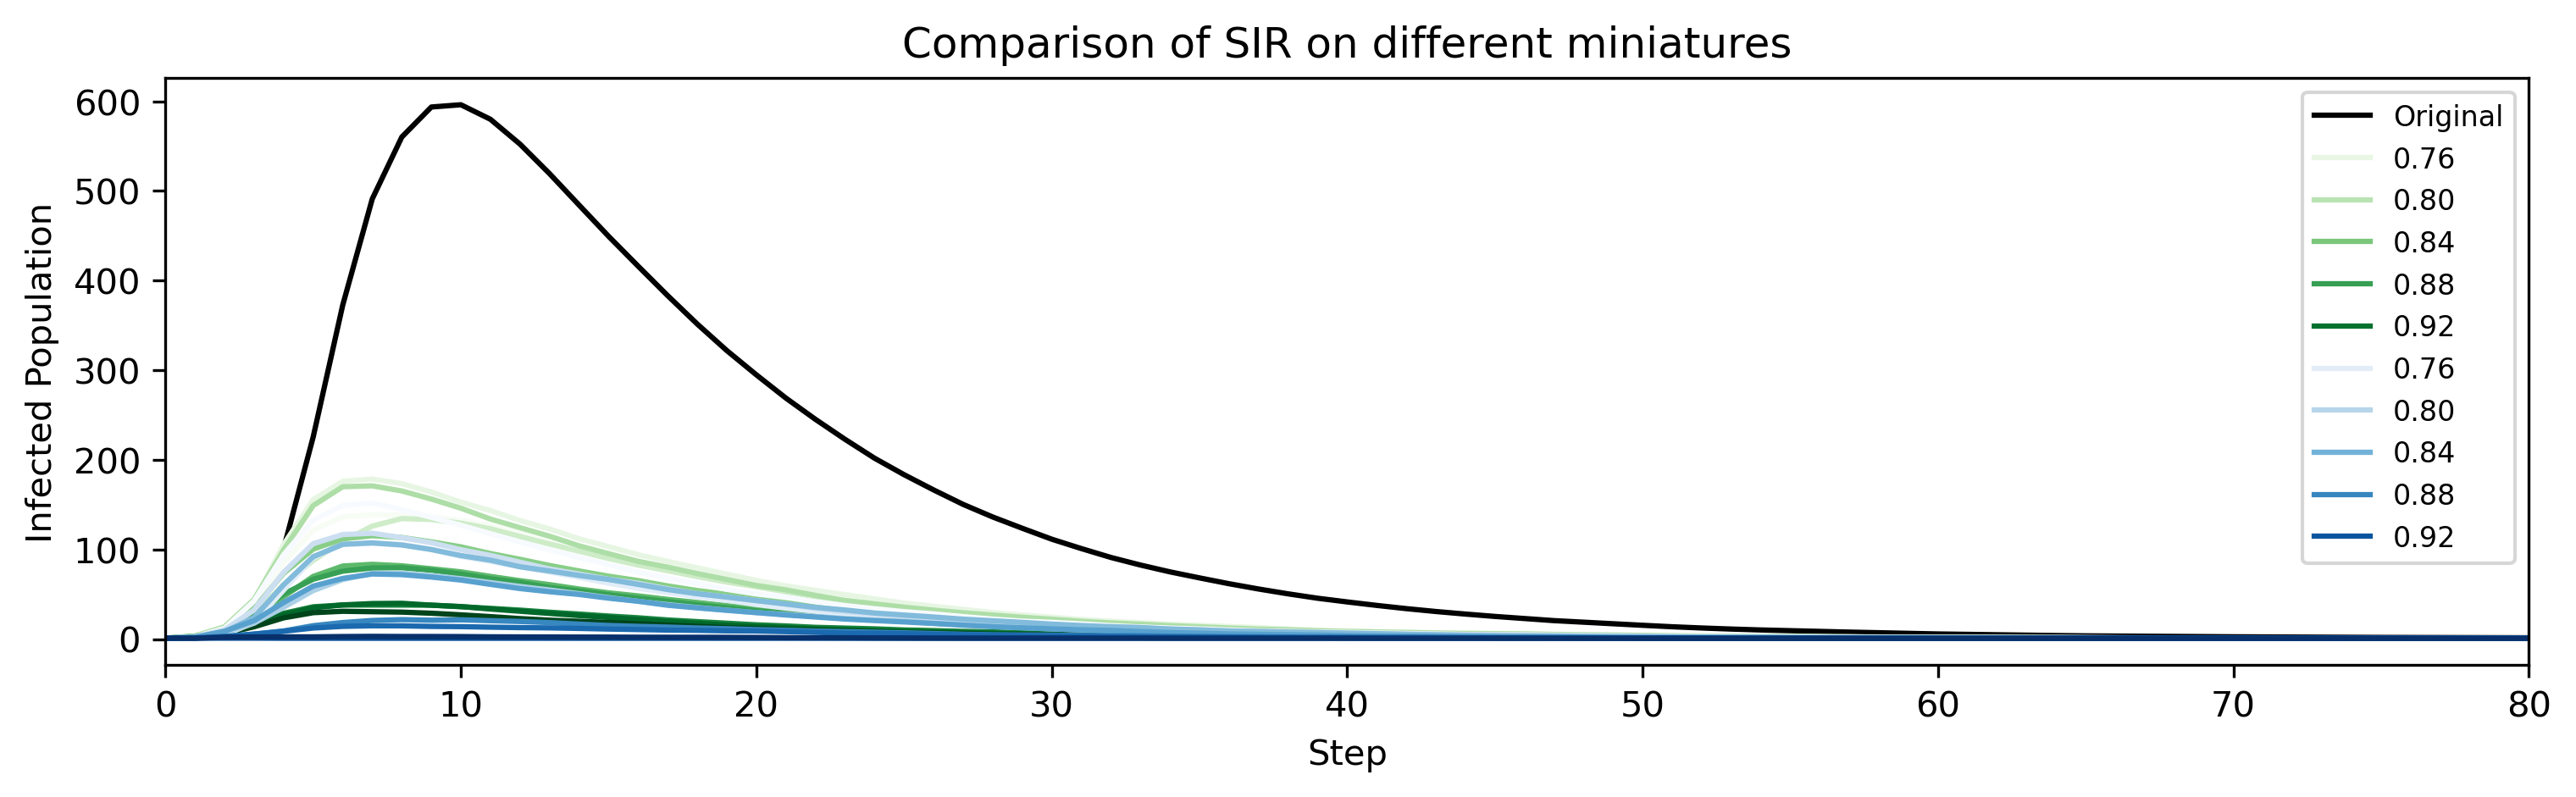

In [375]:
plt.figure(figsize=(12, 3))
sns.lineplot(
    df_results.loc[100],
    x='Step',
    y='I',
    ci=None,
    label='Original',
    color='k'
)

sns.lineplot(
    df_sir_mh.reset_index(),
    x='Step',
    y='I',
    hue='reduction',
    ci=None,
    palette=plt.get_cmap('Greens'),
)

g = sns.lineplot(
    pd.concat((df_sir_coarsening.loc[frac] for frac in reduction[-10:]), keys=reduction[-10:], names=['reduction', 'id']),
    x='Step',
    y='I',
    hue='reduction',
    ci=None,
    palette=plt.get_cmap('Blues'),
)

g.legend(fontsize=8)

plt.xlim([0,80])
plt.ylabel("Infected Population")
plt.title("Comparison of SIR on different miniatures")
plt.savefig("sir_mh_all.png", transparent=True, bbox_inches='tight')

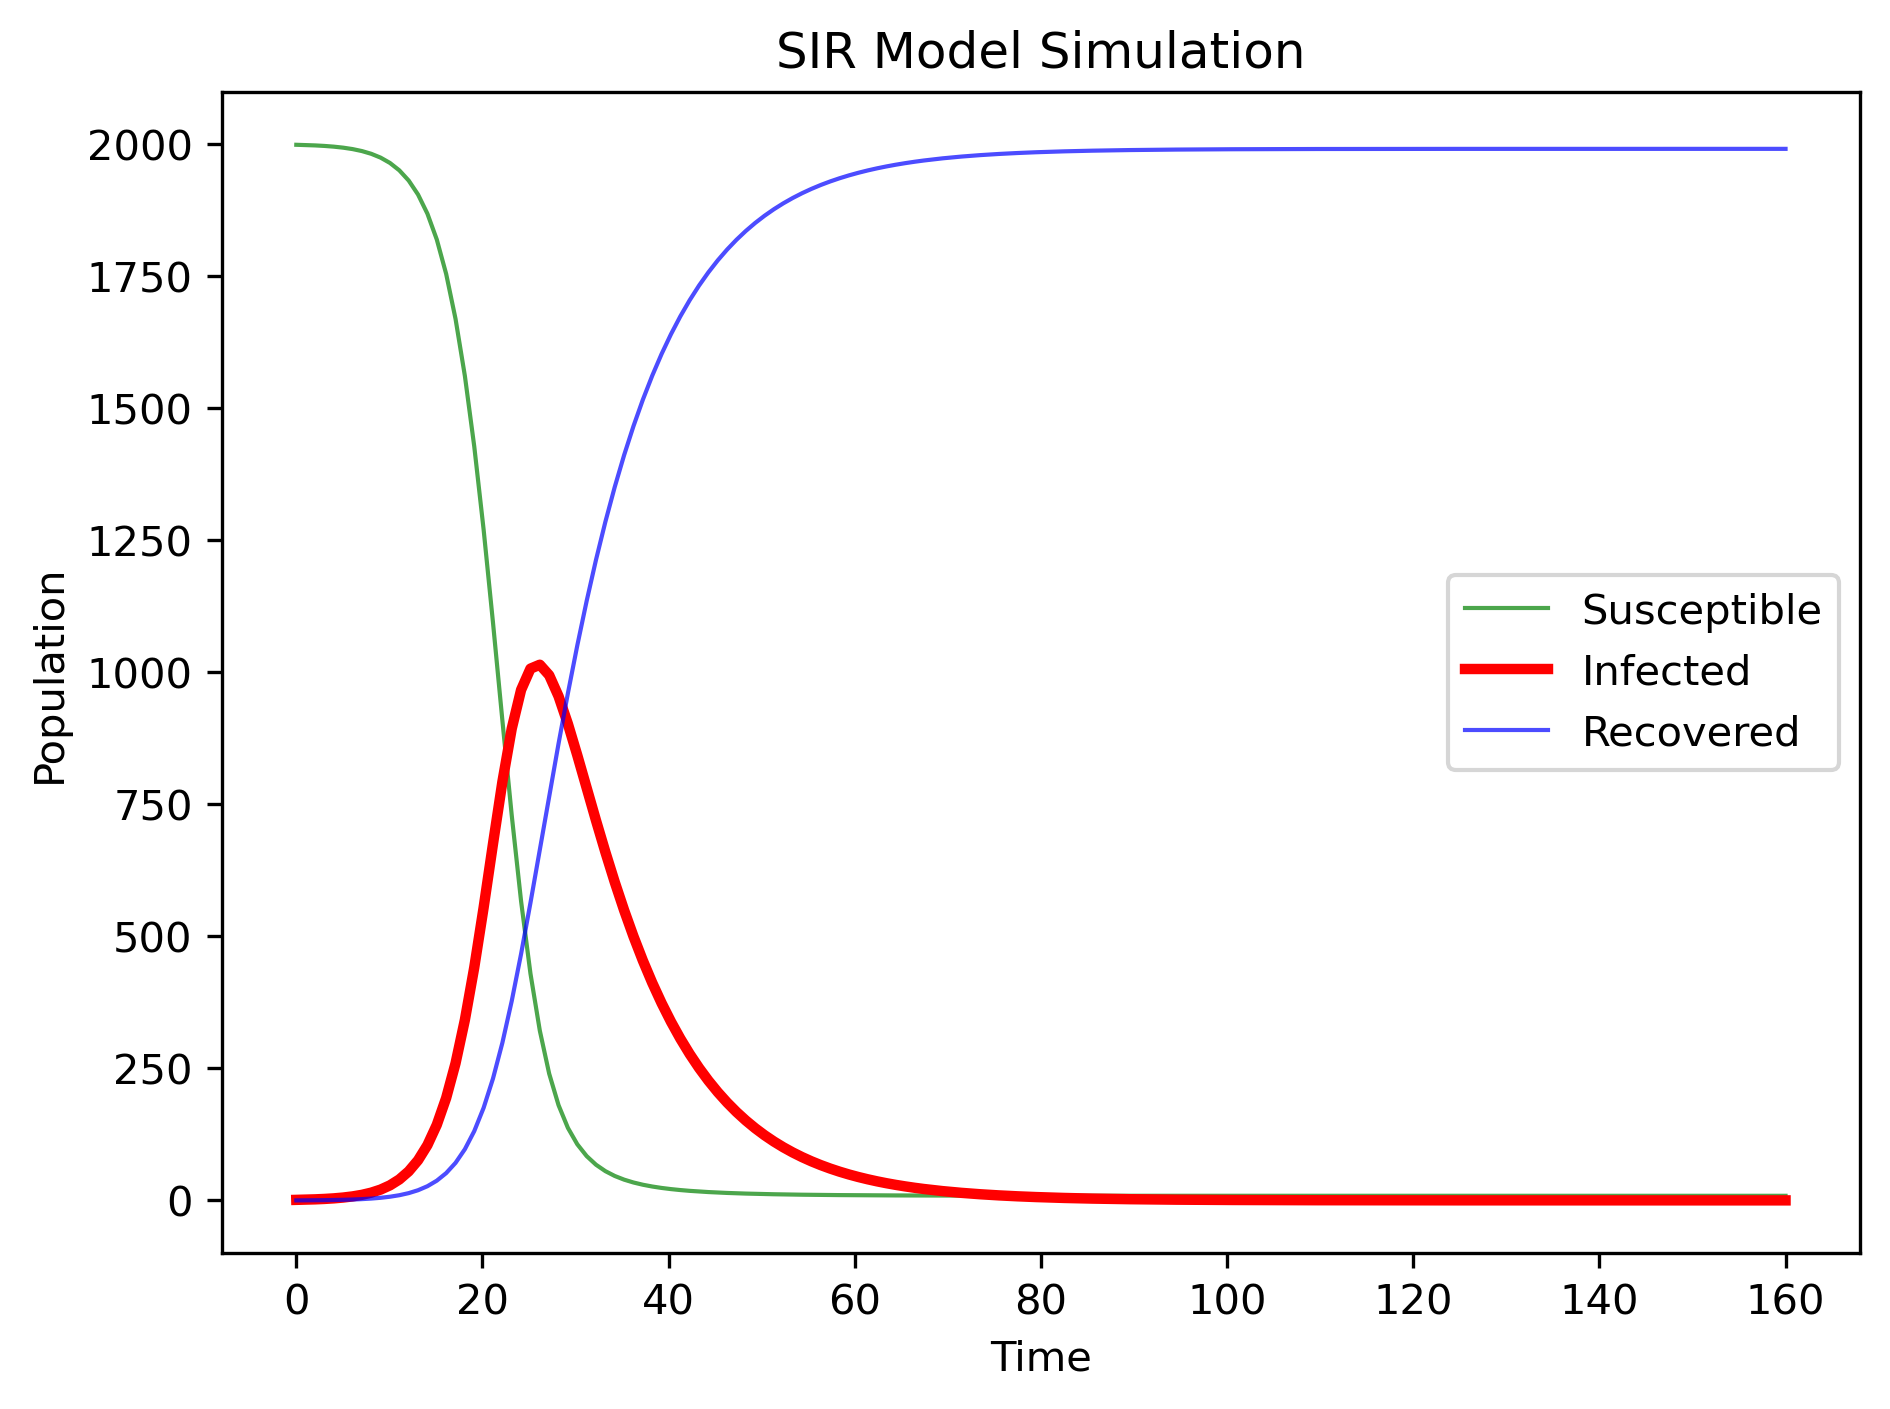

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 0.5    # Infection rate
gamma = 0.1   # Recovery rate
N = 2000      # Total population
I0 = 1        # Initial infected
R0 = 0        # Initial recovered
S0 = N - I0 - R0  # Initial susceptible

# Time grid
T = 160
t = np.linspace(0, T, T)

# Initialize arrays
S, I, R = np.zeros(T), np.zeros(T), np.zeros(T)
S[0], I[0], R[0] = S0, I0, R0

# Simulate SIR dynamics
for i in range(1, T):
    dS = -beta * S[i-1] * I[i-1] / N
    dI = beta * S[i-1] * I[i-1] / N - gamma * I[i-1]
    dR = gamma * I[i-1]

    S[i] = S[i-1] + dS
    I[i] = I[i-1] + dI
    R[i] = R[i-1] + dR

# Plot
plt.plot(t, S, label='Susceptible', color='green', linewidth=1.0, alpha=0.7)
plt.plot(t, I, label='Infected', color='red', linewidth=2.5)
plt.plot(t, R, label='Recovered', color='blue', linewidth=1.0, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model Simulation')
plt.legend()
plt.tight_layout()
plt.savefig("sir_ode.png", transparent=True, bbox_inches='tight')
